In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 
from collections import Counter
from operator import itemgetter

In [2]:
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

In [16]:
def get_frequency(run_id):
    topics = Topic.objects.filter(run_id=run_id)
    
    top_words_combined = []
    for tw in topics.values('top_words'):
        top_words_combined = top_words_combined + tw['top_words']
        
    word_count = Counter(top_words_combined)
    sorted_word_count = sorted(word_count.items(), key=itemgetter(1), reverse=True)

    return sorted_word_count, topics, word_count

In [18]:
def get_word_score(run_id):
    stat = RunStats.objects.get(run_id=run_id)
    K = stat.K
    
    freq, topics, word_count = get_frequency(run_id=run_id)
    word_count_list = word_count.items()
    
    score_dict = {}
    for word, count in word_count_list:
        word_share = count/K
        word_score = (count - 1)/(K-1)
        score_dict[word] = word_score
    
    # find mean score of each topic in one topic model
    # adding topics to list by topic
    sigma_mws = []
    sigma_ttw = []
    for topic in topics.values('top_words'):
        total_word_score = []
        ttw = []
        
        for word in topic['top_words']:
            wws = score_dict[word]
            total_word_score = total_word_score + [wws]
            ttw = ttw + [word]
    
        mean_word_score = sum(total_word_score)/K
        sigma_mws = sigma_mws + [mean_word_score]
        sigma_ttw = sigma_ttw + [ttw]
    
    return sigma_mws, sigma_ttw

### Simple Frequency Analysis

In [17]:
# NMF, K = 10, 40, 70
freq10, topics10, wc10 = get_frequency(1065)
freq40, topics40, wc40 = get_frequency(1058)
freq70, topics70, wc70 = get_frequency(1074)

In [12]:
print("K = 10", freq10[:10])
print("K = 40", freq40[:10])
print("K = 70", freq70[:10])

K = 10 [('deutschland', 4), ('herr', 3), ('jahr', 3), ('prozent', 3), ('deutsch', 2), ('strom', 2), ('land', 2), ('antrag', 1), ('wald', 1), ('rohstoff', 1)]
K = 40 [('deutschland', 7), ('sag', 5), ('land', 4), ('neu', 4), ('mehr', 4), ('jahr', 4), ('frag', 3), ('berat', 3), ('nachhalt', 3), ('gesagt', 3)]
K = 70 [('grun', 6), ('deutsch', 5), ('mehr', 5), ('strom', 5), ('land', 5), ('frag', 4), ('ziel', 4), ('international', 4), ('ausbau', 4), ('fossil', 4)]


In [62]:
for word, count in freq40:
    word5_freq40_l = []
    if count >= 5:
        print(word, count)

deutschland 7
sag 5


In [19]:
mws10, ttw10 = get_word_score(1065)
mws40, ttw40 = get_word_score(1058)
mws70, ttw70 = get_word_score(1074)

In [39]:
df10 = pd.DataFrame(list(zip(mws10, ttw10)), columns=['mws', 'topic'])
df40 = pd.DataFrame(list(zip(mws40, ttw40)), columns=['mws', 'topic'])
df70 = pd.DataFrame(list(zip(mws70, ttw70)), columns=['mws', 'topic'])

In [43]:
# LDA, K = 10, 40, 70
freq10_l, topics10_l, wc10_l = get_frequency(1079)
freq40_l, topics40_l, wc40_l = get_frequency(1063)
freq70_l, topics70_l, wc70_l = get_frequency(1087)

In [44]:
print("K = 10", freq10_l[:10])
print("K = 40", freq40_l[:10])
print("K = 70", freq70_l[:10])

K = 10 [('jahr', 9), ('herr', 8), ('mehr', 6), ('deutschland', 5), ('prozent', 4), ('sag', 4), ('schon', 4), ('deutsch', 3), ('europa', 3), ('land', 3)]
K = 40 [('jahr', 24), ('herr', 24), ('mehr', 20), ('deutschland', 16), ('sag', 15), ('prozent', 10), ('ganz', 10), ('schon', 9), ('land', 8), ('neu', 7)]
K = 70 [('herr', 35), ('jahr', 31), ('mehr', 24), ('deutschland', 23), ('sag', 17), ('bundesregier', 15), ('land', 14), ('schon', 13), ('neu', 12), ('euro', 10)]


In [65]:
for word, count in freq40_l:
    word5_freq40_l = []
    if count >= 5:
        print(word)

jahr
herr
mehr
deutschland
sag
prozent
ganz
schon
land
neu
bundesregier
europa
polit
deutsch
frag


In [45]:
mws10_l, ttw10_l = get_word_score(1079)
mws40_l, ttw40_l = get_word_score(1063)
mws70_l, ttw70_l = get_word_score(1087)

In [46]:
df10_l = pd.DataFrame(list(zip(mws10_l, ttw10_l)), columns=['mws', 'topic'])
df40_l = pd.DataFrame(list(zip(mws40_l, ttw40_l)), columns=['mws', 'topic'])
df70_l = pd.DataFrame(list(zip(mws70_l, ttw70_l)), columns=['mws', 'topic'])

### Plots

In [38]:
sns.set_style('whitegrid')

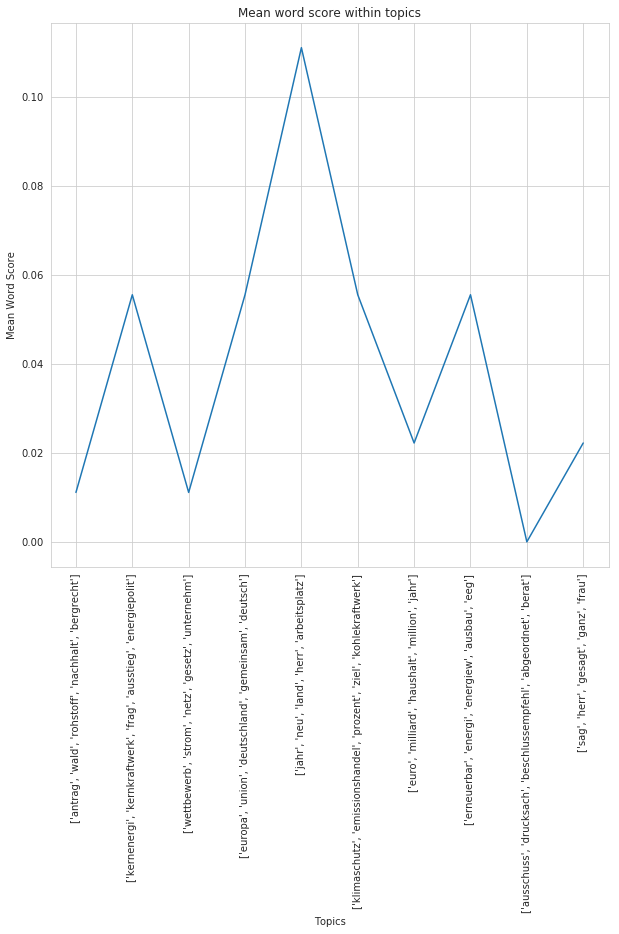

In [37]:
fig, ax = plt.subplots(figsize=(10,10))

sns.lineplot(data=df10['mws'], ci=None, ax = ax)

plt.xticks(np.arange(len(df10['topic'])), [topic[:5] for topic in df10['topic']], rotation='vertical', fontsize=10)

ax.set(xlabel="Topics",ylabel="Mean Word Score", title="Mean word score within topics, K = 10, NMF")
plt.show()

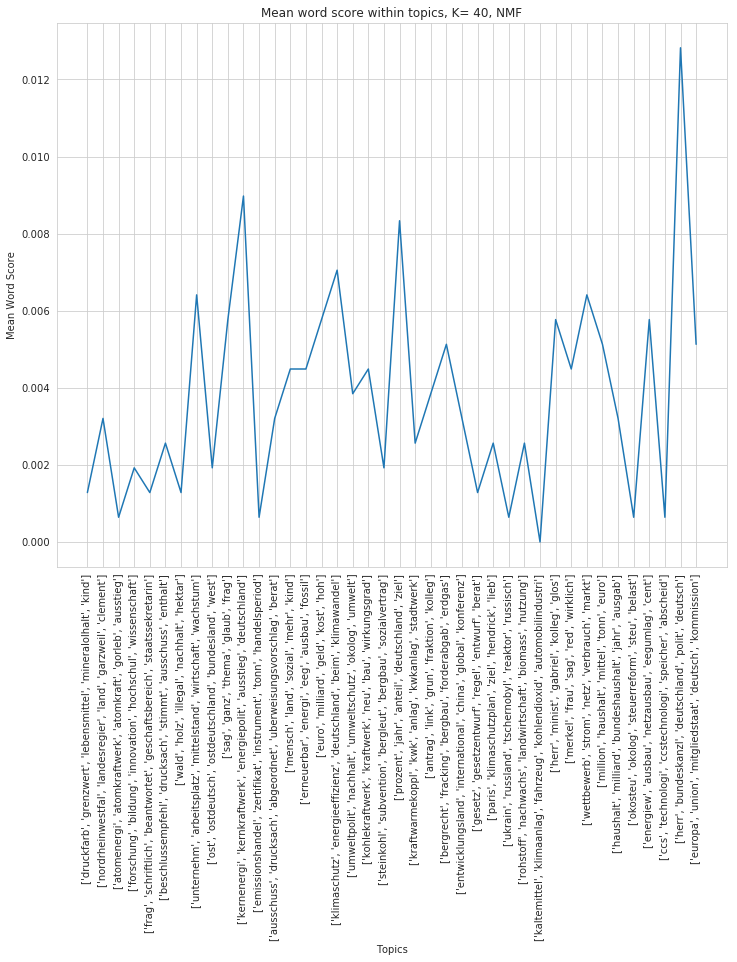

In [77]:
fig, ax = plt.subplots(figsize=(12,10))

sns.lineplot(data=df40['mws'], ci=None, ax = ax)

plt.xticks(np.arange(len(df40['topic'])), [topic[:5] for topic in df40['topic']], rotation='vertical', fontsize=10)

ax.set(xlabel="Topics",ylabel="Mean Word Score", title="Mean word score within topics, K= 40, NMF")
plt.show()

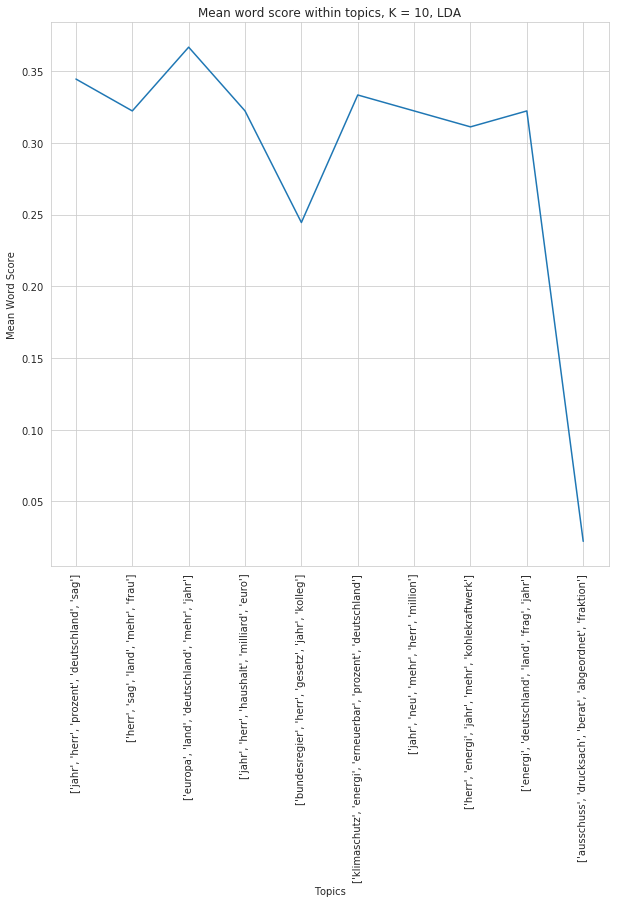

In [47]:
fig, ax = plt.subplots(figsize=(10,10))

sns.lineplot(data=df10_l['mws'], ci=None, ax = ax)

plt.xticks(np.arange(len(df10_l['topic'])), [topic[:5] for topic in df10_l['topic']], rotation='vertical', fontsize=10)

ax.set(xlabel="Topics",ylabel="Mean Word Score", title="Mean word score within topics, K = 10, LDA")
plt.show()

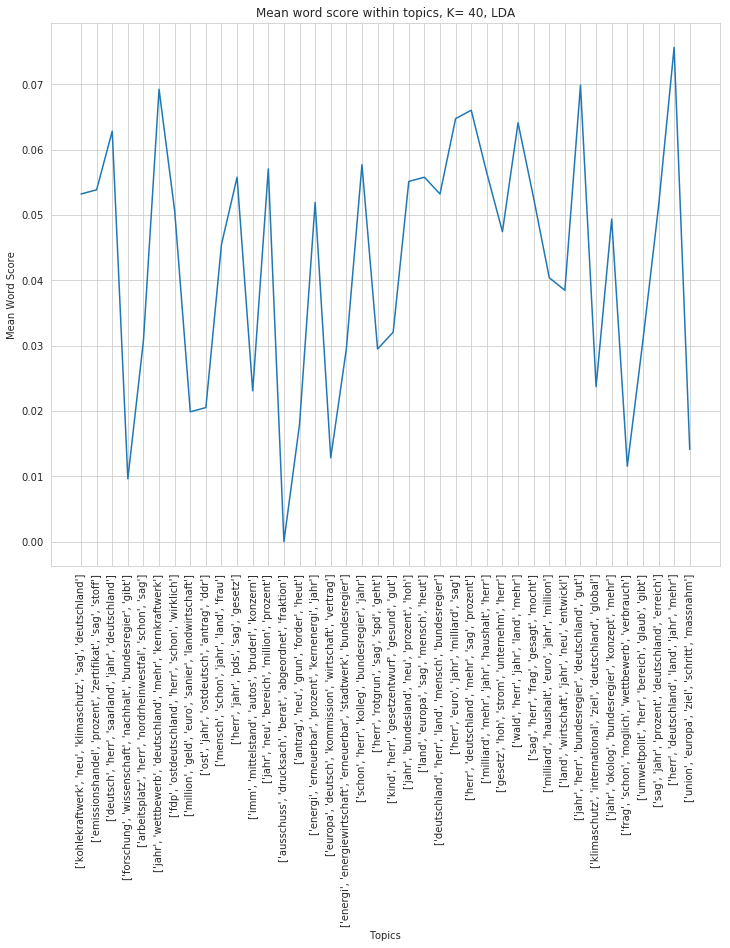

In [48]:
fig, ax = plt.subplots(figsize=(12,10))

sns.lineplot(data=df40_l['mws'], ci=None, ax = ax)

plt.xticks(np.arange(len(df40_l['topic'])), [topic[:5] for topic in df40_l['topic']], rotation='vertical', fontsize=10)

ax.set(xlabel="Topics",ylabel="Mean Word Score", title="Mean word score within topics, K= 40, LDA")
plt.show()

## Modified Stopwords 

### Simplified Frequency Analysis

In [66]:
# NMF, stopwords herr, jahr, mehr, 3, word5
# run_id 1125, 1120, 1126, 1122, 1123

freq_herr, topics_herr, wc_herr = get_frequency(1125)
freq_jahr, topics_jahr, wc_jahr = get_frequency(1120)
freq_mehr, topics_mehr, wc_mehr = get_frequency(1126)
freq_top3, topics_top3, wc_top3 = get_frequency(1122)
freq_word5, topics_word5, wc_word5 = get_frequency(1123)

In [69]:
print("stopword = herr", freq_herr[:10])
print("-")
print("stopword = jahr", freq_jahr[:10])
print("-")
print("stopword = mehr", freq_mehr[:10])
print("-")
print("stopword = herr, jahr, mehr", freq_top3[:10])
print("-")
print("stopword = frequency 5 or more", freq_word5[:10])

stopword = herr [('deutschland', 8), ('prozent', 6), ('jahr', 6), ('neu', 5), ('frag', 5), ('nachhalt', 4), ('deutsch', 4), ('sag', 4), ('kohlekraftwerk', 4), ('subvention', 3)]
-
stopword = jahr [('herr', 8), ('prozent', 8), ('deutschland', 5), ('antrag', 5), ('sag', 4), ('mensch', 4), ('klimaschutz', 4), ('neu', 4), ('frag', 4), ('kolleg', 4)]
-
stopword = mehr [('deutschland', 8), ('herr', 7), ('jahr', 7), ('sag', 5), ('unternehm', 4), ('beschlussempfehl', 3), ('energiepolit', 3), ('milliard', 3), ('haushalt', 3), ('klimaschutz', 3)]
-
stopword = herr, jahr, mehr [('deutschland', 6), ('prozent', 5), ('antrag', 5), ('sag', 4), ('million', 4), ('haushalt', 4), ('neu', 4), ('strom', 4), ('subvention', 4), ('bergleut', 4)]
-
stopword = frequency 5 or more [('herr', 7), ('jahr', 6), ('ziel', 4), ('million', 4), ('klimaschutz', 4), ('neu', 4), ('polit', 4), ('kraftwarmekoppl', 4), ('nachhalt', 3), ('antrag', 3)]


In [72]:
mws_herr, ttw_herr = get_word_score(1125)
mws_jahr, ttw_jahr = get_word_score(1120)
mws_mehr, ttw_mehr = get_word_score(1126)
mws_top3, ttw_top3 = get_word_score(1122)
mws_word5, ttw_word5 = get_word_score(1123)

In [74]:
df_herr = pd.DataFrame(list(zip(mws_herr, ttw_herr)), columns=['mws', 'topic'])
df_jahr = pd.DataFrame(list(zip(mws_jahr, ttw_jahr)), columns=['mws', 'topic'])
df_mehr = pd.DataFrame(list(zip(mws_mehr, ttw_mehr)), columns=['mws', 'topic'])
df_top3 = pd.DataFrame(list(zip(mws_top3, ttw_top3)), columns=['mws', 'topic'])
df_word5 = pd.DataFrame(list(zip(mws_word5, ttw_word5)), columns=['mws', 'topic'])

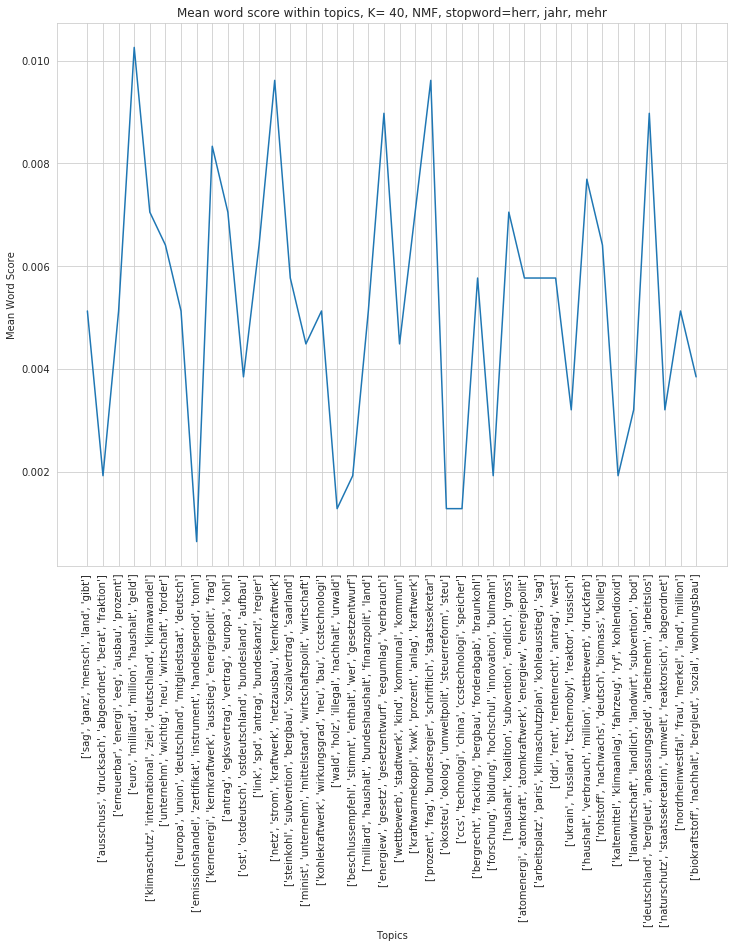

In [79]:
fig, ax = plt.subplots(figsize=(12,10))

sns.lineplot(data=df_top3['mws'], ci=None, ax = ax)

plt.xticks(np.arange(len(df_top3['topic'])), [topic[:5] for topic in df_top3['topic']], rotation='vertical', fontsize=10)

ax.set(xlabel="Topics",ylabel="Mean Word Score", title="Mean word score within topics, K= 40, NMF, stopword=herr, jahr, mehr")
plt.show()

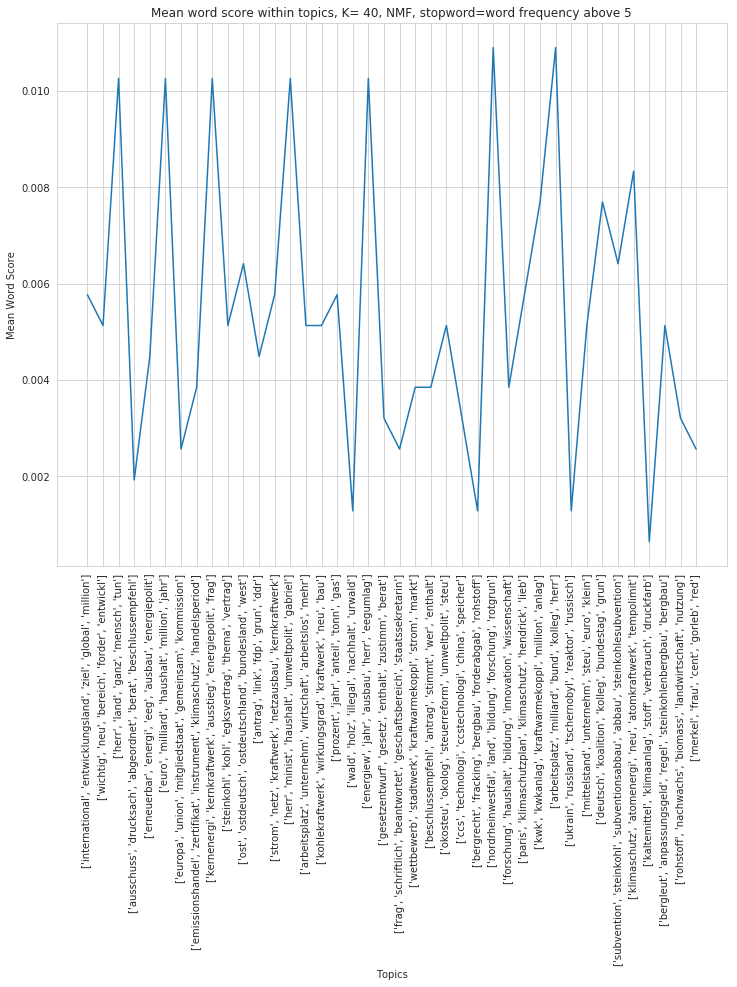

In [81]:
fig, ax = plt.subplots(figsize=(12,10))

sns.lineplot(data=df_word5['mws'], ci=None, ax = ax)

plt.xticks(np.arange(len(df_word5['topic'])), [topic[:5] for topic in df_word5['topic']], rotation='vertical', fontsize=10)

ax.set(xlabel="Topics",ylabel="Mean Word Score", title="Mean word score within topics, K= 40, NMF, stopword=word frequency above 5")
plt.show()

In [67]:
# LDA, stopwords herr, jahr, mehr, 3, word5
# run_id 1116, 1117, 1118, 1115, 1124
freq_herr_l, topics_herr_l, wc_herr_l = get_frequency(1116)
freq_jahr_l, topics_jahr_l, wc_jahr_l = get_frequency(1117)
freq_mehr_l, topics_mehr_l, wc_mehr_l = get_frequency(1118)
freq_top3_l, topics_top3_l, wc_top3_l = get_frequency(1115)
freq_word5_l, topics_word5_l, wc_word5_l = get_frequency(1124)

In [70]:
print("stopword = herr", freq_herr_l[:10])
print("-")
print("stopword = jahr", freq_jahr_l[:10])
print("-")
print("stopword = mehr", freq_mehr_l[:10])
print("-")
print("stopword = herr, jahr, mehr", freq_top3_l[:10])
print("-")
print("stopword = frequency 5 or more", freq_word5_l[:10])

stopword = herr [('jahr', 25), ('mehr', 19), ('sag', 18), ('deutschland', 15), ('prozent', 13), ('schon', 12), ('neu', 10), ('bundesregier', 10), ('land', 9), ('ganz', 8)]
-
stopword = jahr [('herr', 22), ('mehr', 20), ('sag', 20), ('deutschland', 15), ('prozent', 12), ('neu', 11), ('schon', 10), ('land', 10), ('ganz', 9), ('bundesregier', 9)]
-
stopword = mehr [('jahr', 26), ('herr', 25), ('deutschland', 19), ('sag', 14), ('neu', 10), ('schon', 9), ('land', 9), ('prozent', 9), ('frau', 7), ('ganz', 7)]
-
stopword = herr, jahr, mehr [('deutschland', 22), ('sag', 18), ('schon', 11), ('land', 10), ('neu', 10), ('prozent', 10), ('ganz', 10), ('polit', 8), ('kolleg', 8), ('bundesregier', 8)]
-
stopword = frequency 5 or more [('imm', 11), ('heut', 11), ('mensch', 10), ('gross', 9), ('kolleg', 8), ('energi', 8), ('dafur', 7), ('geht', 7), ('euro', 6), ('erst', 6)]


In [73]:
mws_herr_l, ttw_herr_l = get_word_score(1116)
mws_jahr_l, ttw_jahr_l = get_word_score(1117)
mws_mehr_l, ttw_mehr_l = get_word_score(1118)
mws_top3_l, ttw_top3_l = get_word_score(1115)
mws_word5_l, ttw_word5_l = get_word_score(1124)

In [75]:
df_herr_l = pd.DataFrame(list(zip(mws_herr_l, ttw_herr_l)), columns=['mws', 'topic'])
df_jahr_l = pd.DataFrame(list(zip(mws_jahr_l, ttw_jahr_l)), columns=['mws', 'topic'])
df_mehr_l = pd.DataFrame(list(zip(mws_mehr_l, ttw_mehr_l)), columns=['mws', 'topic'])
df_top3_l = pd.DataFrame(list(zip(mws_top3_l, ttw_top3_l)), columns=['mws', 'topic'])
df_word5_l = pd.DataFrame(list(zip(mws_word5_l, ttw_word5_l)), columns=['mws', 'topic'])

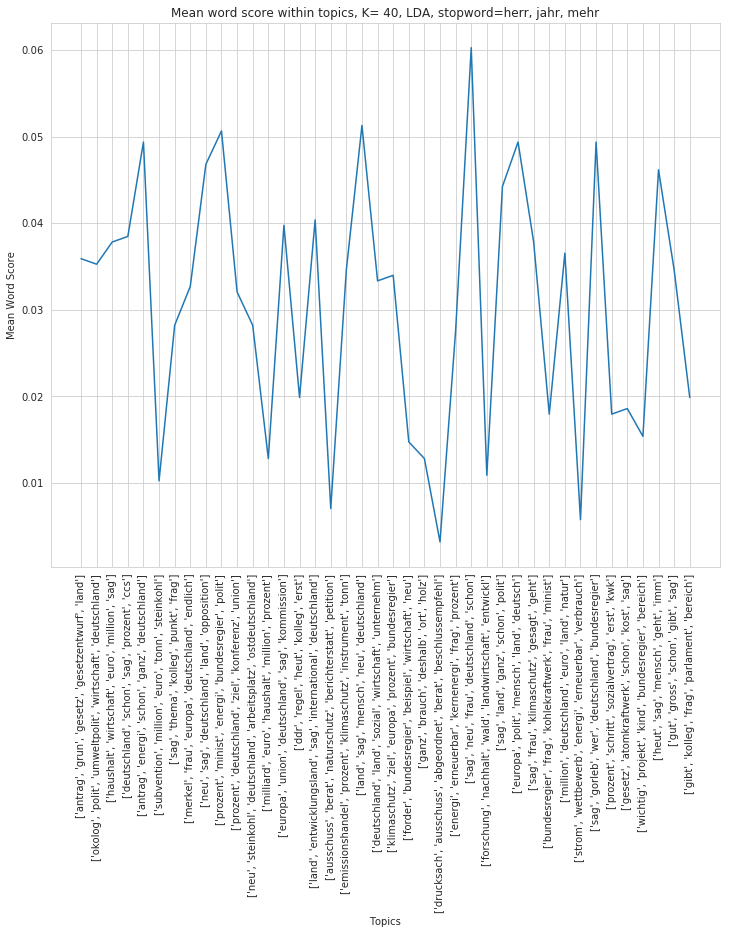

In [82]:
fig, ax = plt.subplots(figsize=(12,10))

sns.lineplot(data=df_top3_l['mws'], ci=None, ax = ax)

plt.xticks(np.arange(len(df_top3_l['topic'])), [topic[:5] for topic in df_top3_l['topic']], rotation='vertical', fontsize=10)

ax.set(xlabel="Topics",ylabel="Mean Word Score", title="Mean word score within topics, K= 40, LDA, stopword=herr, jahr, mehr")
plt.show()

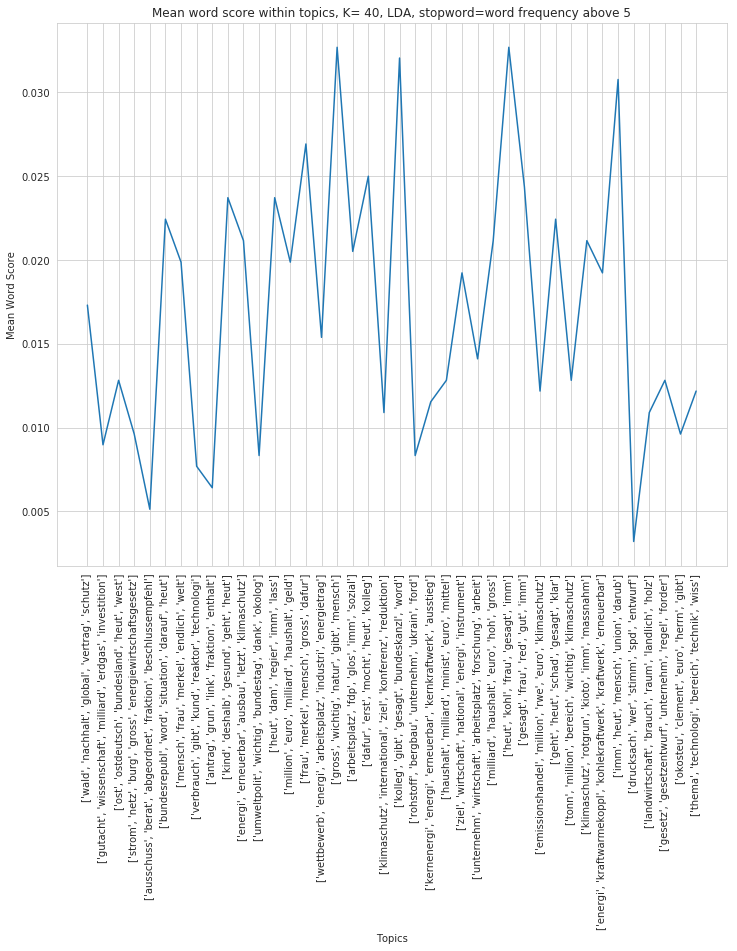

In [83]:
fig, ax = plt.subplots(figsize=(12,10))

sns.lineplot(data=df_word5_l['mws'], ci=None, ax = ax)

plt.xticks(np.arange(len(df_word5_l['topic'])), [topic[:5] for topic in df_word5_l['topic']], rotation='vertical', fontsize=10)

ax.set(xlabel="Topics",ylabel="Mean Word Score", title="Mean word score within topics, K= 40, LDA, stopword=word frequency above 5")
plt.show()